Preamble

In [1]:
from __future__ import division
import tensorflow as tf
import numpy as np
import tarfile
import os
import matplotlib.pyplot as plt
import time
import pandas as pd

Import Data

In [2]:
def csv_to_numpy_array(filePath, delimiter):
    return np.genfromtxt(filePath, delimiter=delimiter, dtype=None)

In [3]:
# X is the TF matrix, Y is the binary response
trainX = csv_to_numpy_array("trainX.csv", delimiter=",")
trainY = csv_to_numpy_array("trainY.csv", delimiter=",")
testX = csv_to_numpy_array("testX.csv", delimiter=",")
testY = csv_to_numpy_array("testY.csv", delimiter=",")

In [4]:
# remove the index column from dataset
trainX = trainX[:,1:21039]
trainY = trainY[:,1:21039]
testX = testX[:,1:21039]
testY = testY[:,1:21039]

In [5]:
# remove column headers
trainX = trainX[1:21038]
trainY = trainY[1:21038]
testX = testX[1:21038]
testY = testY[1:21038]

Global Parameters

In [6]:
# DATA SET PARAMETERS
# get dimensions for different variables and placeholders:
# numFeatures = the number of words extracted from each article
numFeatures = trainX.shape[1]
# numLabels = number of classes we're predicting (here it's 4 - Bahai, DorothyDay, IntegralYoga, and SeaShepherds)
numLabels = trainY.shape[1]

In [7]:
# TRAINING SESSION PARAMETERS
# number of times we iterate through training data
# tensorboard shows that accuracy plateaus at ~25k epochs
numEpochs = 27000
# a smarter learning rate for gradientOptimizer
learningRate = tf.train.exponential_decay(learning_rate = 0.0008,
                                          global_step =1,
                                          decay_steps = trainX.shape[0],
                                          decay_rate = 0.95,
                                          staircase = True)

Placeholders

In [8]:
# X = X-matrix/feature-matrix/data-matrix...It's a tensor to hold the article data. 'None' here 
# means that we can hold any number of articles
X = tf.placeholder(tf.float32, [None, numFeatures])
# yGold = Y-matrix/label-matrix/labels...This will be our correct answers matrix. Every row has
# is binary, with 1 representing their group. 'None' here means that we can hold any number of emails
yGold = tf.placeholder(tf.float32, [None, numLabels])

Variables

In [9]:
# Values are randomly sampled from a Gaussian with a standard deviation of:
# sqrt(6/(numInputNodes + numOutputNodes + 1))
weights = tf.Variable(tf.random_normal([numFeatures,numLabels],
                                        mean = 0,
                                        stddev = (np.sqrt(6/numFeatures + numLabels + 1)),
                                        name = "weights"))
bias = tf.Variable(tf.random_normal([1,numLabels],
                                     mean = 0,
                                     stddev = (np.sqrt(6/numFeatures + numLabels + 1)),
                                     name = "bias"))

Ops

In [10]:
######################
### PREDICTION OPS ###
######################
# INITIALIZE our weights and biases
init_OP = tf.initialize_all_variables()
# PREDICTION ALGORITHM  i.e. FEEDFORWARD ALGORITHM
apply_weights_OP = tf.matmul(X, weights, name = "apply_weights")
add_bias_OP = tf.add(apply_weights_OP, bias, name = "add_bias")
activation_OP = tf.nn.sigmoid(add_bias_OP, name = "activation") # sigmoid = activation function; output = 0/1

In [11]:
#####################
### EVALUATION OP ###
#####################
# COST FUNCTION i.e. MEAN SQUARED ERROR
cost_OP = tf.nn.l2_loss(activation_OP-yGold, name = "squared_error_cost")

In [12]:
#######################
### OPTIMIZATION OP ###
#######################
# OPTIMIZATION ALGORITHM i.e. GRADIENT DESCENT
training_OP = tf.train.GradientDescentOptimizer(learningRate).minimize(cost_OP)

Computational Graph and Session

step 0, training accuracy 0.258333
step 0, cost 268.488
step 0, change in cost268.488
step 10, training accuracy 0.258333
step 10, cost 267.695
step 10, change in cost0.793213
step 20, training accuracy 0.258333
step 20, cost 267.411
step 20, change in cost0.283936
step 30, training accuracy 0.258333
step 30, cost 265.592
step 30, change in cost1.81885
step 40, training accuracy 0.258333
step 40, cost 265.538
step 40, change in cost0.0539551
step 50, training accuracy 0.258333
step 50, cost 265.521
step 50, change in cost0.0176086
step 60, training accuracy 0.258333
step 60, cost 264.05
step 60, change in cost1.47067
step 70, training accuracy 0.258333
step 70, cost 264.009
step 70, change in cost0.0407104
step 80, training accuracy 0.258333
step 80, cost 263.474
step 80, change in cost0.535553
step 90, training accuracy 0.258333
step 90, cost 262.94
step 90, change in cost0.533997
step 100, training accuracy 0.258333
step 100, cost 262.51
step 100, change in cost0.430145
step 110, tra

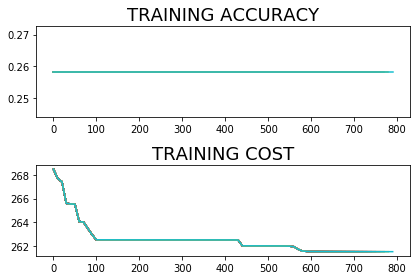

In [13]:
# GRAPH LIVE UPDATING
epoch_values = []
accuracy_values = []
cost_values = []
# Turn on interactive plotting
plt.ion()
# Create the main, super plot
fig = plt.figure()
# Create two subplots on their own axes and give titles
ax1 = plt.subplot("211")
ax1.set_title("TRAINING ACCURACY", fontsize=18)
ax2 = plt.subplot("212")
ax2.set_title("TRAINING COST", fontsize=18)
plt.tight_layout()

# RUN THE GRAPH

# Create a tensorflow session
sess = tf.Session()
# Initialize all tensorflow variables
sess.run(init_OP)

# Ops for vizualization
# argmax(activation_OP, 1) gives the label our model thought was most likely
# argmax(yGold, 1) is the correct label
correct_predictions_OP = tf.equal(tf.argmax(activation_OP, 1), tf.argmax(yGold, 1))
# False is 0 and True is 1, what was our average?
accuracy_OP = tf.reduce_mean(tf.cast(correct_predictions_OP, "float"))
# Summary op for regression output
activation_summary_OP = tf.histogram_summary("output", activation_OP)
# Summary op for accuracy
accuracy_summary_OP = tf.scalar_summary("accuracy", accuracy_OP)
# Summary op for cost
cost_summary_OP = tf.scalar_summary("cost", cost_OP)
# Summary ops to check how variables (W, b) are updating after each iteration
weightSummary = tf.histogram_summary("weights", weights.eval(session=sess))
biasSummary = tf.histogram_summary("biases", bias.eval(session=sess))
# Merge all summaries
all_summary_OPS = tf.merge_all_summaries()
# Summary writer
writer = tf.train.SummaryWriter("summary_logs", sess.graph)

# Initialize reporting variables
cost = 0
diff = 1

# Training epochs
for i in range(numEpochs):
    if i > 1 and diff < .0001:
        print("change in cost%g; convergence."%diff)
        break
    else:
        # Run training step
        step = sess.run(training_OP, feed_dict={X: trainX, yGold: trainY})
        # Report occasional stats
        if i % 10 == 0:
            # Add epoch to epoch_values
            epoch_values.append(i)
            # Generate accuracy stats on test data
            summary_results, train_accuracy, newCost = sess.run(
                [all_summary_OPS, accuracy_OP, cost_OP],
                feed_dict = {X: trainX, yGold: trainY}
            )
            # Add accuracy to live graphing variable
            accuracy_values.append(train_accuracy)
            # Add cost to live graphing variable
            cost_values.append(newCost)
            # Write summary stats to writer
            writer.add_summary(summary_results, i)
            # Re-assign values for variables
            diff = abs(newCost - cost)
            cost = newCost
            
            # generate print statements
            print("step %d, training accuracy %g"%(i, train_accuracy))
            print("step %d, cost %g"%(i, newCost))
            print("step %d, change in cost%g"%(i, diff))
            
            # Plot progress to our two subplots
            accuracyLine, = ax1.plot(epoch_values, accuracy_values)
            costLine, = ax2.plot(epoch_values, cost_values)
            fig.canvas.draw()
            time.sleep(1)

# How well do we perform on held-out test data?
print("final accuracy on test set: %s" %str(sess.run(accuracy_OP, feed_dict={X: testX, yGold: testY})))

Save the Trained Variables

In [ ]:
# Create Saver
# saver = tf.train.Saver()
# Save variables to .ckpt file
# saver.save(sess, "trained_variables.ckpt")

# Close tensorflow session
sess.close()